In [5]:
#buat upload file zip ke colab
import zipfile
import os
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  with zipfile.ZipFile(fn, 'r') as zip_ref:
    zip_ref.extractall('data')

print("File dalam direktori 'data':")
print(os.listdir('data'))

Saving E-commerce-public-dataset.zip to E-commerce-public-dataset.zip
File dalam direktori 'data':
['E-Commerce Public Dataset']


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


data_path = 'data/data'

customers_df = pd.read_csv(os.path.join(data_path, 'customers_dataset.csv'))
orders_df = pd.read_csv(os.path.join(data_path, 'orders_dataset.csv'))
order_items_df = pd.read_csv(os.path.join(data_path, 'order_items_dataset.csv'))
order_payments_df = pd.read_csv(os.path.join(data_path, 'order_payments_dataset.csv'))
products_df = pd.read_csv(os.path.join(data_path, 'products_dataset.csv'))
product_translation_df = pd.read_csv(os.path.join(data_path, 'product_category_name_translation.csv'))
sellers_df = pd.read_csv(os.path.join(data_path, 'sellers_dataset.csv'))

print("Data berhasil dimuat!")

def create_main_df():

    df = pd.merge(orders_df, order_items_df, on='order_id')
    df = pd.merge(df, products_df, on='product_id')

    df = pd.merge(df, order_payments_df, on='order_id')

    df = pd.merge(df, customers_df, on='customer_id')

    df = pd.merge(df, product_translation_df, on='product_category_name')

    for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
        df[col] = pd.to_datetime(df[col])

    return df

main_df = create_main_df()
print("\nDataFrame utama berhasil dibuat dengan bentuk:", main_df.shape)
print(main_df.info())


Data berhasil dimuat!

DataFrame utama berhasil dibuat dengan bentuk: (115878, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115878 entries, 0 to 115877
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115878 non-null  object        
 1   customer_id                    115878 non-null  object        
 2   order_status                   115878 non-null  object        
 3   order_purchase_timestamp       115878 non-null  datetime64[ns]
 4   order_approved_at              115864 non-null  datetime64[ns]
 5   order_delivered_carrier_date   114673 non-null  datetime64[ns]
 6   order_delivered_customer_date  113383 non-null  datetime64[ns]
 7   order_estimated_delivery_date  115878 non-null  datetime64[ns]
 8   order_item_id                  115878 non-null  int64         
 9   product_id                     115878 non-null  objec

**1. Bagaimana demografi pelanggan kita berdasarkan lokasi?**

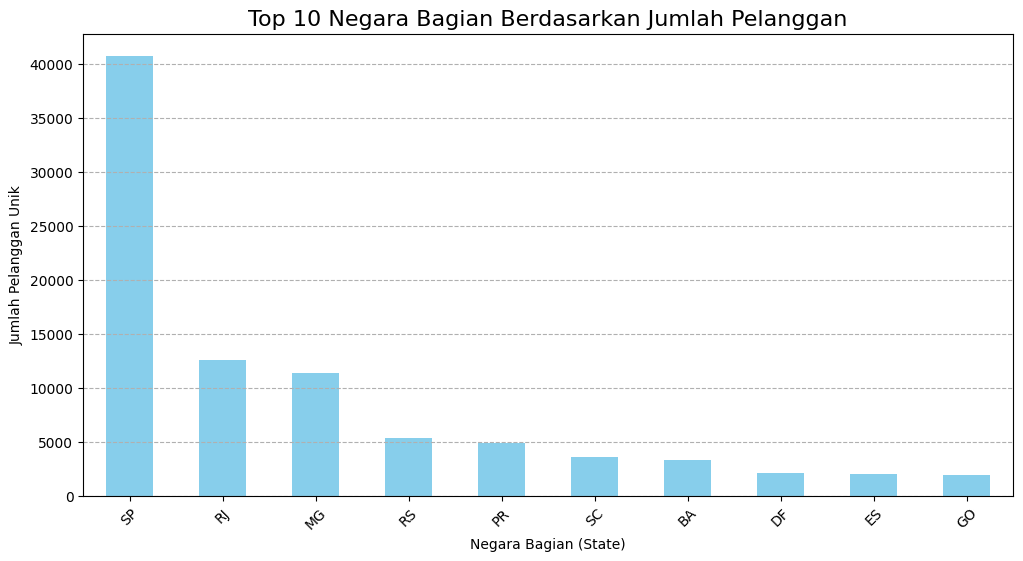

In [10]:
customer_by_state = main_df.groupby('customer_state')['customer_id'].nunique().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
customer_by_state.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Negara Bagian Berdasarkan Jumlah Pelanggan', fontsize=16)
plt.xlabel('Negara Bagian (State)')
plt.ylabel('Jumlah Pelanggan Unik')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

2. **Kategori produk apa yang memiliki performa terbaik dan terburuk?**

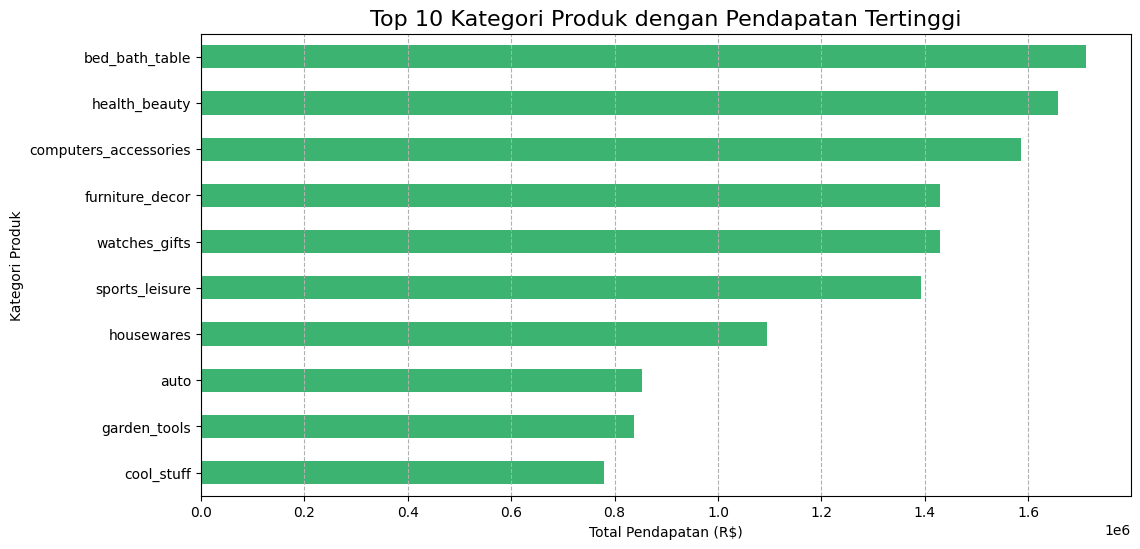

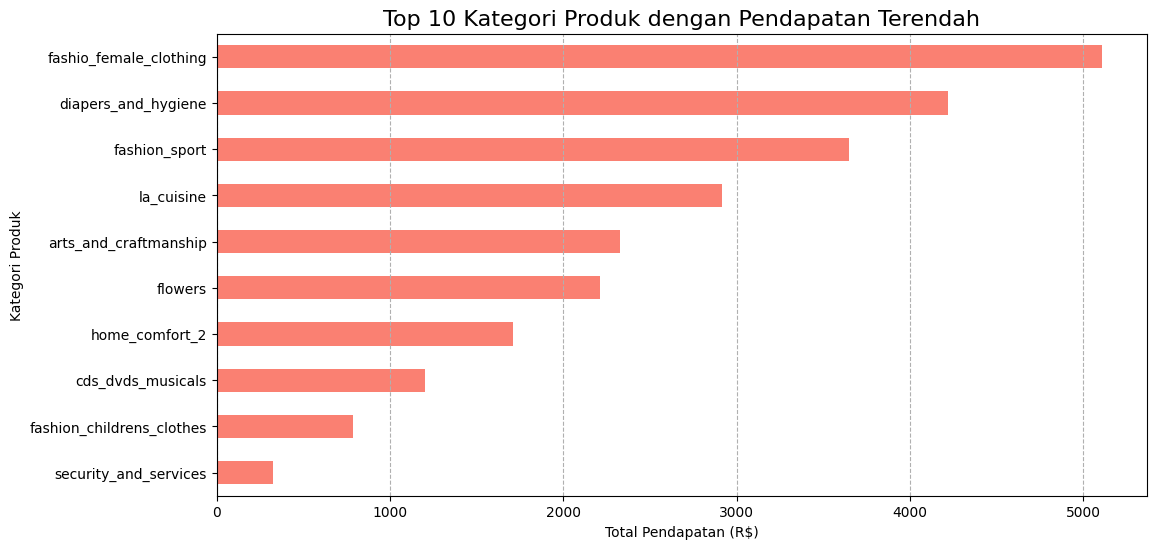

In [18]:
category_performance = main_df.groupby('product_category_name_english')['payment_value'].sum().sort_values(ascending=False)


plt.figure(figsize=(12, 6))
category_performance.head(10).plot(kind='barh', color='mediumseagreen').invert_yaxis()
plt.title('Top 10 Kategori Produk dengan Pendapatan Tertinggi', fontsize=16)
plt.xlabel('Total Pendapatan (R$)')
plt.ylabel('Kategori Produk')
plt.grid(axis='x', linestyle='--')
plt.show()

plt.figure(figsize=(12, 6))
category_performance.tail(10).plot(kind='barh', color='salmon').invert_yaxis()
plt.title('Top 10 Kategori Produk dengan Pendapatan Terendah', fontsize=16)
plt.xlabel('Total Pendapatan (R$)')
plt.ylabel('Kategori Produk')
plt.grid(axis='x', linestyle='--')
plt.show()

3. **Siapa pelanggan terbaik kita berdasarkan analisis RFM?**

In [19]:
print("\nMemulai Analisis RFM...")

snapshot_date = main_df['order_purchase_timestamp'].max() + pd.DateOffset(days=1)
print(f"Tanggal snapshot untuk analisis RFM: {snapshot_date}")

rfm_df = main_df.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days, 
    'order_id': 'nunique', 
    'payment_value': 'sum' 

rfm_df.rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency',
    'payment_value': 'Monetary'
}, inplace=True)

rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1]) 
rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]) 
rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]) 


rfm_df['RFM_Score'] = rfm_df['R_score'].astype(str) + rfm_df['F_score'].astype(str) + rfm_df['M_score'].astype(str)

print("\nTop 10 Pelanggan Terbaik Berdasarkan RFM Score:")
best_customers = rfm_df[rfm_df['RFM_Score'] == '555'].sort_values('Monetary', ascending=False).head(10)
print(best_customers)


Memulai Analisis RFM...
Tanggal snapshot untuk analisis RFM: 2018-09-04 09:06:57

Top 10 Pelanggan Terbaik Berdasarkan RFM Score:
                            customer_id  Recency  Frequency  Monetary R_score  \
89966  ec5b2ba62e574342386871631fafd3fc       50          1  29099.52       5   
94056  f7622098214b4634b7fe7eee269b5426       94          1  19457.04       5   
90297  ed583a2a1eaf0dedc33af816153e8b8c       63          1  17069.76       5   
85473  e0a2412720e9ea4f26c1ac985f6a7358       53          1   9618.88       5   
77976  cc803a2c412833101651d3f90ca7de24       95          1   8891.00       5   
84277  dd3f1762eb601f41c5e289fa08dbc6bf       47          1   8108.64       5   
83740  dbe9495069f4ddb6875dfc83462d616f       28          1   7215.84       5   
93041  f48d464a0baaea338cb25f816991ab1f       40          1   6922.21       5   
82803  d95ca02ab50105ccce682bdf9ffdc3b4       40          1   5948.36       5   
79417  d057951b2e010930970d111b015bc37d       42          1